In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
import mesa
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class Wall:
    def __init__(self, arrayWall, coord, dmgPoints, model):
        super().__init__(arrayWall, coord, dmgPoints)
        self.arrayWall = arrayWall #array
        self.coord = coord #tuple
        self.dmgPoints = dmgPoints #array
        #self.model = BoardModel()

    # fireFighterMoves(self: current wall, agent: Firefighter, destineCoord: (x, y))
    # If return true, hay una pared, no puede pasar
    # If return false, el bombero puede pasar
    '''
    | ! | - Aqui falta poner que la pared de la celda compartiendo pared, tambien se destruye de su lado.
    '''
    def fireFighterWallMoves(self, agent, destineCoord):
        x, y = self.coord
        destineX, destineY = destineCoord
        # if < es Left, if == no se mueve x
        if x != destineX:
            ## arrayWall[0] ó arrayWall[2] ó arrayWall[-2]
            if self.arrayWall[(y - destineY) - 1] != 1:
                return True
        elif y != destineY:
        # arrayWall[1] ó arrayWall[3] ó arrayWall[-1]
            if self.arrayWall[(x - destineX)] != 1:
                return True
        else:
            print('El agente no se mueve con esta coordenada destino')
    # takeDamage(self: Wall, damage: int, damageDirection: int)
    # Suma daño a la pared y la quita si es destruida
    # Direction [0]:up [1]:Left [2]:Down [3]:Right
    def takeDamage(self, damage, dmgDirection):
        self.dmgPoints[dmgDirection] += damage
        if self.dmgPoints[dmgDirection] == 2:
            self.dmgPoints[dmgDirection] = 0
            self.arrayWall[dmgDirection] = 0
            print("Wall has been destroyed")
            # Para contador de cuántas paredes han sido destruidas
            return 1
        else:
            print("Wall took 1 of damage")
            # Para contador de cuántas paredes han sido destruidas
            return 0

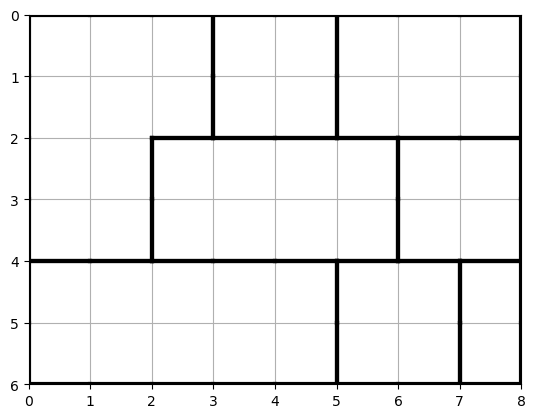

In [3]:
wallData = [['1001', '1000', '1100', '1001', '1100', '1001', '1000', '1100'],
           ['0001', '0000', '0110', '0011', '0110', '0011', '0010', '0110'],
           ['0001', '0100', '1001', '1000', '1000', '1100', '1001', '1100'],
           ['0011', '0110', '0011', '0010', '0010', '0110', '0011', '0110'],
           ['1001', '1000', '1000', '1000', '1100', '1001', '1100', '1101'],
           ['0011', '0010', '0010', '0010', '0110', '0011', '0110', '0111']]

FirePOI = [
    [None, None, None, None, None, None, None, None],
    [None, "F", "F", "V", None, None, None, None],
    [None, "F", "F", "F", "F", None, None, None],
    [None, None, None, "F", None, None, None, None],
    ["FA", None, None, None, None, "F", "F", "V"],
    [None, None, None, None, None, "F", None, None],
]

"""
for i in range(wallData):
    for j in range(wallData[0]):
        new Wall(wallData[i][j], (i - 1, j - 1), 0)
"""
rows = len(wallData)
cols = len(wallData[0])

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid()

# Dibujar las paredes según los valores en wallData
#matplotlib.rcParams['linewidth'] = 2
for i in range(0, rows):
    for j in range(0, cols):
        cell = wallData[i][j]
        if cell[0] == "1":  # Pared al norte
            ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
        if cell[1] == "1":  # Pared al este
            ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
        if cell[2] == "1":  # Pared al sur
            ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
        if cell[3] == "1":  # Pared al oeste
            ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)
    
# Ajustar la visualización
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

# Lista de Pendientes
- Recoger victima despues de hacer una acción donde la baja.
- Checar array de las Doors
- interactDoor()
- def takeVictim(self) ✅

In [5]:
class FireFighterAgent(Agent):
    def __init__(self, actionPoints, victim, Model, knockOut):
        super.__init__(actionPoints, victim, Model, knockOut)
        self.actionPoints = actionPoints
        self.victim = victim
        self.model = Model
        self.knockOut = knockOut
        self.memoryVictim = 0 #Recordar si bajo a una víctima, antes de moverse
    def step(self, actionFirefighter, coordDirectionAgent, FirePOI, directionAgent):
        if self.actionPoints <= 0:
            return  # No action if there are no action points left

        if self.victim == 0:
            if actionFirefighter == 'Move':
                move(FirePOI, self.model, coordDirectionAgent)
            elif actionFirefighter == "axeWall":
                axeWall(FirePOI, self.model, directionAgent)
            elif actionFirefighter == 'interactDoor':
                # interactDoor function call here
                pass
            elif actionFirefighter == 'extinguishFire':
                # extinguishFire function call here
                pass
            elif actionFirefighter == 'leaveVictim':
                print('agent.step() - No victim with agent')
                return

            self.actionPoints -= 1

        elif self.victim == 1:
            if actionFirefighter == 'leaveVictim':
                leaveVictim(FirePOI)
            elif actionFirefighter == 'Move':
                move(FirePOI, self.model, coordDirectionAgent)
            elif actionFirefighter in ['extinguishFire', 'axeWall', 'interactDoor'] and self.actionPoints <= 2:
                self.actionPoints -= 1  # These actions cost more AP
                leaveVictim(FirePOI)
                self.step(actionFirefighter, directionAgent, FirePOI)
                return

            self.actionPoints -= 1
                
    def knockOut(self, exitCoord, vicitmsLostCount):
        self.knockOut = 1
        if self.victim == 1:
            self.victim == 0
            victimsLostCount += 1
        self.coord = None
        return victimsLostCount

    def move(self, FirePOI, Wall, destineCoord):
        
        neighbors = self.model.grid.get_neighbors()
        for neighbor in neighbors:
            if neighbor.pos == destineCoord:
                self.actionPoints += 1
                return
            elif neighbor.pos != destineCoord:
                #Wall conditional
                if fireFighterWallMoves(Wall, self, destineCoord):
                    # | ! | - Fire conditional 
                    self.model.grid.move_agent(destineCoord)
                else:
                    self.actionPoints += 1
                    return
    
    def axeWall(self, FirePOI, Wall, axeDirection):
        if self.victim == 1:
            self.victim == 0
            firePOI[self.pos] = 'V'
            # | ! | - No puede estar cargando con la víctima cuando destruye la pared 
        Wall.takeDamage(1, axeDirection)
        
    def leaveVicitm(self, FirePOI):
        if FirePOI[self.pos] == None:
            self.victim = 0
            self.memoryVictim = 1
        else:
            self.actionPoints -= 1
            print('No se puede poner víctima')
            return False
            

    def takeVictim(self):
        if FirePOI[self.pos] == 'V':
            if self.victim == 0:
                self.victim = 1
                print('Recoger víctima')
            else:
                self.actionPoints -= 1
                print('Ya cargas con una víctima')
                return False
        else:
            self.actionPoints -= 1
            print('Falsa Alarma | No hay una victima aquí')
            return False
            
   # | ! | - Door como se va a poner??????         
    def interactDoor(self, Door, actionFirefighter):
        if self.victim == 0:
            if actionFirefighter == 'openDoor':
                if Door == 1: #Closed
                    self.actionPoints -= 1
                    Door = 0
                else:
                    self.actionPoints += 1
                    print('Door already open')
            if actionFirefighter == 'closeDoor':
                if Door == 0: #Open
                    self.actinoPoints -= 1
                    Door = 1
                else:
                    self.actionPoints += 1
                    print('Door already closed')
        else:
            self.leaveVcitim(FirePOI)

    def extinguishFire(self, FirePOI, firePos):
        if FirePOI[firePos] == 'F':
            self.actionPoints -= 1
            FirePOI[firePos] = 'S'
        elif FirePOI[firePos] == 'S':
            self.actionPoints -= 1
            FirePOI[firePos] = None
        else:
            self.actionPoints += 1
            return    
    